In [1071]:
import process_data
from process_data import get_dfs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit  
from scipy.special import voigt_profile
from scipy.ndimage import gaussian_filter1d
import os
import importlib
importlib.reload(process_data)

<module 'process_data' from '/Users/xnimir/Desktop/Sn exp 2024/process_data.py'>

In [1072]:
def gaussian(x, A, mu, sigma, B):
    return A * np.exp(-((x - mu)**2) / (2 * sigma**2)) + B

In [1073]:
def standard_lorentzian(x, amplitude, center, width, offset):
    return amplitude * width**2 / ((x - center)**2 + width**2) + offset

In [1074]:
def super_lorentzian(x, amplitude, center, width, power, offset):
    # Generalized Lorentzian with adjustable power for wider wings
    return amplitude * width**power / ((x - center)**power + width**power) + offset

In [1075]:
def modified_voigt(x, amplitude, center, g_width, l_width, offset, modification_factor):
    # Modified Voigt that allows for stronger wings
    basic_voigt = amplitude * voigt_profile(x - center, g_width, l_width)
    wing_enhancement = modification_factor * amplitude * (g_width**2 / ((x - center)**2 + g_width**2))**0.5
    return basic_voigt + wing_enhancement + offset

In [1076]:
def fitting(x,y):
    x_fit = np.linspace(np.min(x), np.max(x), 500)

    initial_guess = [np.max(y), x[np.argmax(y)], np.std(x), 0]
    bounds = ([0, 0, 0, 0], [np.inf, np.max(x), np.inf, np.inf])
    popt, pcov = curve_fit(gaussian, x, y, p0=initial_guess, bounds=bounds, sigma=np.sqrt(y), absolute_sigma=True)
    y_fit = gaussian(x_fit, *popt)
    # print(initial_guess)
    # print(popt)

    return x_fit, y_fit, popt, pcov

In [1077]:
def get_scatter_plot(data_df, time_df, freq_df, scaled_df_wtf, file):
    x = data_df['Bin center']
    y = data_df['Count raw']
    y_1 = gaussian_filter1d(data_df['Count raw'], sigma=2)
    # y = data_df['Total_count']
    # y_norm = data_df['Norm count']
    x_fit, y_fit, popt, pcov = fitting(x, y)

    fwhm = 2.355 * popt[2] * 1E6
    fit_errors = np.sqrt(np.diag(pcov))
    mu_error = fit_errors[1]

    plt.figure()
    # plt.errorbar(x, y, yerr=np.sqrt(y), fmt='o', capsize=3)
    plt.scatter(x,y)
    plt.plot(x_fit, y_fit)
    plt.title(f'{file}')
    plt.xlabel('frequency (THz)')
    plt.ylabel('binned counts')

    label = f'mu={popt[1]:.6f} THz\nfwhm={fwhm:.2f} MHz'
    plt.text(0.95, 0.95, label, fontsize=10,
                        verticalalignment='top', horizontalalignment='right',
                        transform=plt.gca().transAxes) 
    plt.show()
    plt.scatter(scaled_df_wtf['Bin center'], scaled_df_wtf['Count raw'])
    # plt.title('Frequency')
    # plt.scatter(freq_df['Bin center'], freq_df['Count raw'], color='red')
    # plt.show()
    # plt.title('Time')
    # plt.scatter(time_df['Bin center'], time_df['Count raw'])
    # plt.show()

    return popt[1], fwhm

In [1078]:
def compare_dfs(df1, df2):
    print("DataFrame 1 shape:", df1.shape)
    print("DataFrame 2 shape:", df2.shape)
    
    print("\nDataFrame 1 columns:", df1.columns.tolist())
    print("DataFrame 2 columns:", df2.columns.tolist())
    
    print("\nDataFrame 1 index:", df1.index.dtype)
    print("DataFrame 2 index:", df2.index.dtype)
    
    # Find common columns
    common_cols = list(set(df1.columns) & set(df2.columns))
    print("\nCommon columns:", common_cols)
    
    if common_cols:
        # Reset index to make sure we can compare
        df1_reset = df1[common_cols].reset_index(drop=True).round(6)
        df2_reset = df2[common_cols].reset_index(drop=True).round(6)
        
        try:
            # Compare values in common columns
            differences = (df1_reset != df2_reset).any(axis=1)
            diff_rows = differences[differences].index
            
            if len(diff_rows) > 0:
                print(f"\nFound {len(diff_rows)} rows with differences")
                for idx in diff_rows[:5]:  # Show first 5 differences
                    print(f"\nRow {idx}:")
                    print("df1:", df1_reset.iloc[idx].to_dict())
                    print("df2:", df2_reset.iloc[idx].to_dict())
            else:
                print("\nNo differences found in common columns")
                
        except Exception as e:
            print(f"\nError comparing values: {e}")
            
        # Show some sample rows from each DataFrame
        print("\nFirst few rows of DataFrame 1:")
        print(df1.head())
        print("\nFirst few rows of DataFrame 2:")
        print(df2.head())

In [1079]:
def main(folder_path):
    for filename, scaled_df, time_df, freq_df, scaled_df_wtf in get_dfs(folder_path):
        get_scatter_plot(scaled_df, time_df, freq_df, scaled_df_wtf, filename)
        compare_dfs(scaled_df, scaled_df_wtf)

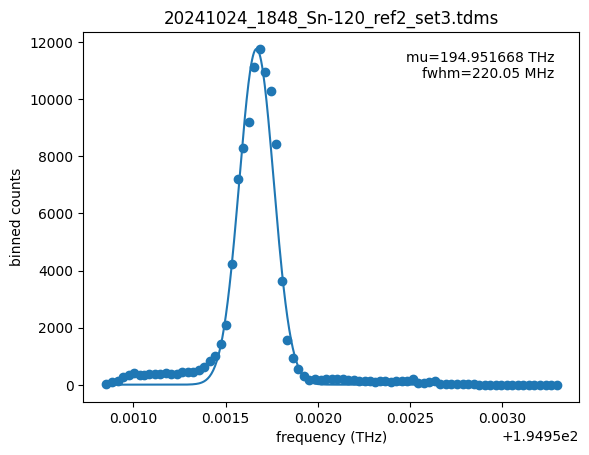

DataFrame 1 shape: (83, 4)
DataFrame 2 shape: (83, 4)

DataFrame 1 columns: ['Freq bin', 'Count raw', 'Bin center', 'Count-bkg']
DataFrame 2 columns: ['Freq bin', 'Count raw', 'Bin center', 'Count-bkg']

DataFrame 1 index: int64
DataFrame 2 index: int64

Common columns: ['Count raw', 'Freq bin', 'Bin center', 'Count-bkg']

No differences found in common columns

First few rows of DataFrame 1:
                 Freq bin  Count raw  Bin center  Count-bkg
0  (194.95083, 194.95087]         34  194.950850       -9.2
1   (194.95087, 194.9509]         96  194.950885       52.8
2   (194.9509, 194.95093]        152  194.950915      108.8
3  (194.95093, 194.95096]        265  194.950945      221.8
4  (194.95096, 194.95099]        346  194.950975      302.8

First few rows of DataFrame 2:
                 Freq bin  Count raw  Bin center  Count-bkg
0  (194.95083, 194.95087]         34  194.950850       -9.2
1   (194.95087, 194.9509]         96  194.950885       52.8
2   (194.9509, 194.95093]       

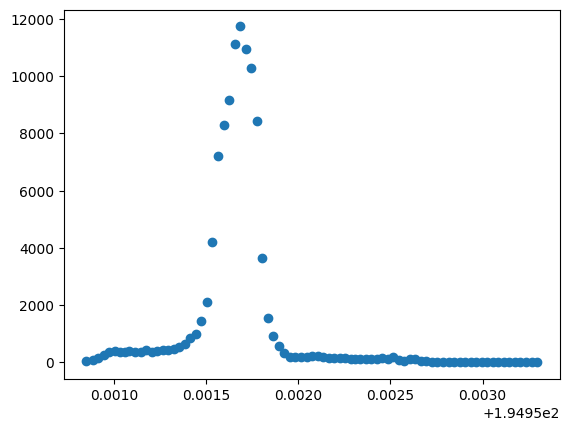

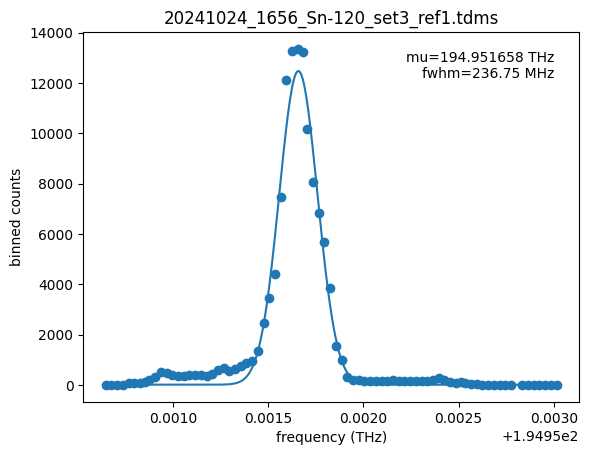

DataFrame 1 shape: (80, 4)
DataFrame 2 shape: (80, 4)

DataFrame 1 columns: ['Freq bin', 'Count raw', 'Bin center', 'Count-bkg']
DataFrame 2 columns: ['Freq bin', 'Count raw', 'Bin center', 'Count-bkg']

DataFrame 1 index: int64
DataFrame 2 index: int64

Common columns: ['Count raw', 'Freq bin', 'Bin center', 'Count-bkg']

No differences found in common columns

First few rows of DataFrame 1:
                 Freq bin  Count raw  Bin center  Count-bkg
0  (194.95063, 194.95066]          5  194.950645      -39.6
1  (194.95066, 194.95069]          6  194.950675      -38.6
2  (194.95069, 194.95072]          5  194.950705      -39.6
3  (194.95072, 194.95075]         14  194.950735      -30.6
4  (194.95075, 194.95078]         76  194.950765       31.4

First few rows of DataFrame 2:
                 Freq bin  Count raw  Bin center  Count-bkg
0  (194.95063, 194.95066]          5  194.950645      -39.6
1  (194.95066, 194.95069]          6  194.950675      -38.6
2  (194.95069, 194.95072]       

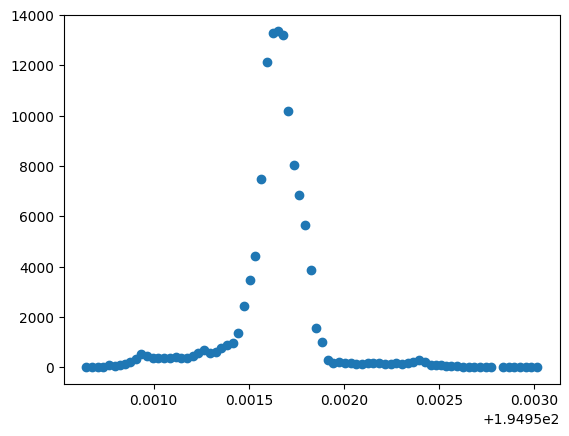

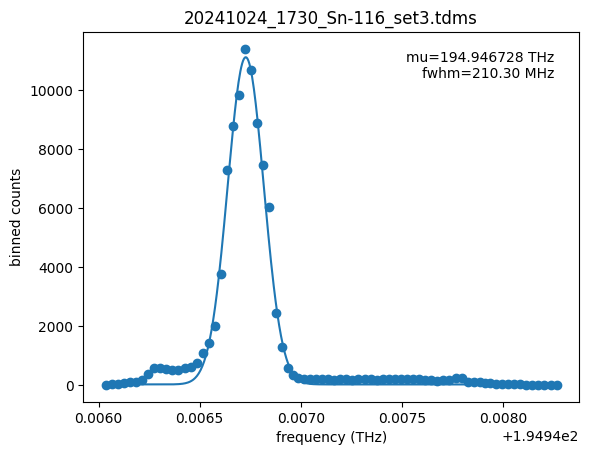

DataFrame 1 shape: (76, 4)
DataFrame 2 shape: (76, 4)

DataFrame 1 columns: ['Freq bin', 'Count raw', 'Bin center', 'Count-bkg']
DataFrame 2 columns: ['Freq bin', 'Count raw', 'Bin center', 'Count-bkg']

DataFrame 1 index: int64
DataFrame 2 index: int64

Common columns: ['Count raw', 'Freq bin', 'Bin center', 'Count-bkg']

No differences found in common columns

First few rows of DataFrame 1:
                 Freq bin  Count raw  Bin center  Count-bkg
0  (194.94602, 194.94605]         15  194.946035      -78.0
1  (194.94605, 194.94608]         17  194.946065      -76.0
2  (194.94608, 194.94611]         39  194.946095      -54.0
3  (194.94611, 194.94614]         63  194.946125      -30.0
4  (194.94614, 194.94617]         87  194.946155       -6.0

First few rows of DataFrame 2:
                 Freq bin  Count raw  Bin center  Count-bkg
0  (194.94602, 194.94605]         15  194.946035      -78.0
1  (194.94605, 194.94608]         17  194.946065      -76.0
2  (194.94608, 194.94611]       

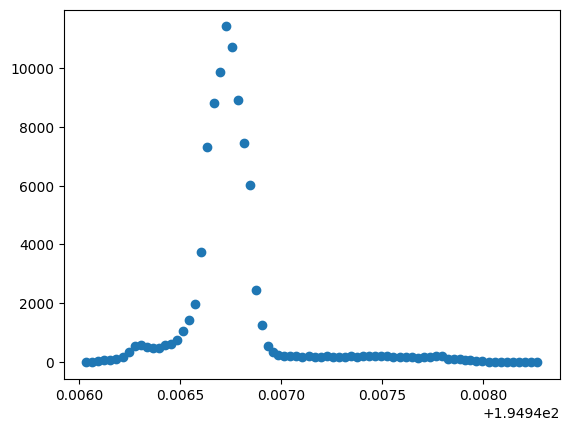

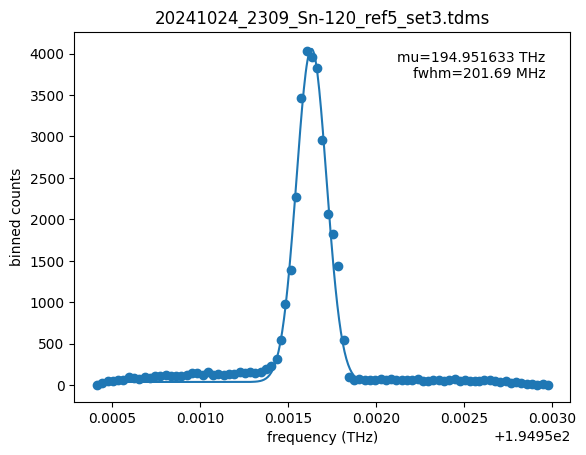

DataFrame 1 shape: (87, 4)
DataFrame 2 shape: (87, 4)

DataFrame 1 columns: ['Freq bin', 'Count raw', 'Bin center', 'Count-bkg']
DataFrame 2 columns: ['Freq bin', 'Count raw', 'Bin center', 'Count-bkg']

DataFrame 1 index: int64
DataFrame 2 index: int64

Common columns: ['Count raw', 'Freq bin', 'Bin center', 'Count-bkg']

No differences found in common columns

First few rows of DataFrame 1:
                 Freq bin  Count raw  Bin center  Count-bkg
0   (194.9504, 194.95043]          8  194.950415      -31.4
1  (194.95043, 194.95046]         21  194.950445      -18.4
2  (194.95046, 194.95049]         45  194.950475        5.6
3  (194.95049, 194.95052]         45  194.950505        5.6
4  (194.95052, 194.95055]         64  194.950535       24.6

First few rows of DataFrame 2:
                 Freq bin  Count raw  Bin center  Count-bkg
0   (194.9504, 194.95043]          8  194.950415      -31.4
1  (194.95043, 194.95046]         21  194.950445      -18.4
2  (194.95046, 194.95049]       

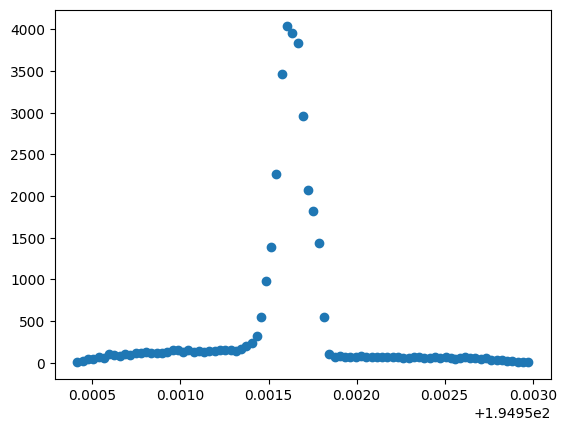

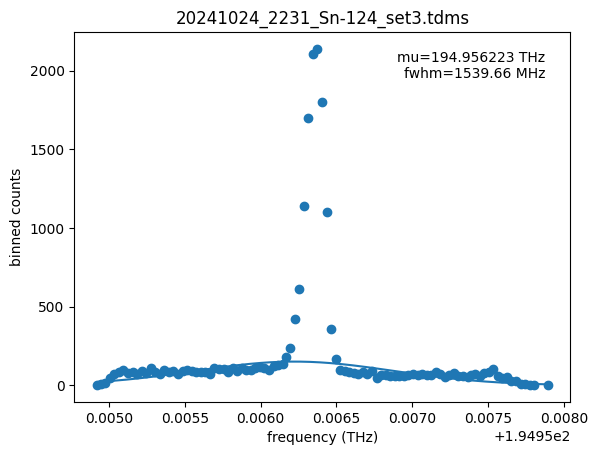

DataFrame 1 shape: (99, 4)
DataFrame 2 shape: (99, 4)

DataFrame 1 columns: ['Freq bin', 'Count raw', 'Bin center', 'Count-bkg']
DataFrame 2 columns: ['Freq bin', 'Count raw', 'Bin center', 'Count-bkg']

DataFrame 1 index: int64
DataFrame 2 index: int64

Common columns: ['Count raw', 'Freq bin', 'Bin center', 'Count-bkg']

No differences found in common columns

First few rows of DataFrame 1:
                 Freq bin  Count raw  Bin center  Count-bkg
0   (194.9549, 194.95494]          4  194.954920      -84.2
1  (194.95494, 194.95496]          7  194.954950      -81.2
2  (194.95496, 194.95499]         14  194.954975      -74.2
3  (194.95499, 194.95502]         45  194.955005      -43.2
4  (194.95502, 194.95505]         74  194.955035      -14.2

First few rows of DataFrame 2:
                 Freq bin  Count raw  Bin center  Count-bkg
0   (194.9549, 194.95494]          4  194.954920      -84.2
1  (194.95494, 194.95496]          7  194.954950      -81.2
2  (194.95496, 194.95499]       

In [ ]:
def single_set():
    folder_path = '/Users/xnimir/Desktop/Sn exp 2024/data/set3/'
    main(folder_path)
single_set()